# Tarefa 1


# Vinicius C

imagem por imagem identificar onde esta o carro, calcular o ponto central do carro em cada uma das imagens, gerar uma imagem preta a onde aparece a trajetoria do carro, ou seja, desenhar os pontos centrais de todas as imagens juntas e traçar uma linha interconectando os pontos na sequencia das imagens.

In [68]:
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import os

# Solução

In [69]:
# Carregando as imagens.
images_dir = os.path.join(os.getcwd(), 'dataexp1') # Pasta onde estão as imagens.

# diretorio de cada imagem.
dirs = []
for dir_ in os.listdir(images_dir):
    dirs.append(os.path.join(images_dir ,dir_))        

In [77]:
def get_ref_frame(dirs):
    """
    Cria uma imagem usando um pedaço do fundo da imagem 0
    e um pedaço da imagem 6, assim obtendo tudo que é constante 
    nas imagens (o fundo sem o carrinho).
    """
    frame1 = cv.imread(dirs[0], 0)
    frame2 = cv.imread(dirs[6], 0)
    
    ref = np.zeros_like(frame1)
    ref[:,:1400] = frame1[:,:1400] 
    ref[:,1400:] = frame2[:,1400:]
    
    return ref

In [79]:
def get_cars_center(frame, ref2, thres = 120):
    """
    description:
        Recorta o logo da imagem, verifica se a media é inferior a thres, se for
        ajusta para thres, obtem a diferença entre o background (ref) e cada uma
        das imagems, opos isso aplica operações morfologicas de erosão, abertura e 
        fechamento para eliminar oque não é de interesse e criar uma mascara que
        representa a região do carrinho, com isso, aplica-se esta mascara na imagem
        original. calcula-se o centro do carrinho usando contornos, e por fim
        uma imagem contendo a localização do carrinho e seu centro é plotada.
    
    return:
       lista contendo os centros list{int,int} , imagens dos carrinhos detectados list{ndarray}.
    """
    
    framergb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    frame[930:1060,0:460] = 0
    ref2[930:1060,0:460] = 0
    
    # adjust brightness.
    mean = np.mean(frame)
    if mean < thres:
        #print('mean', mean)
        frame = cv.multiply(frame, thres/mean)      
        #frame = cv.multiply(frame, 2.2)
        #frame = np.uint8(((frame/255)**0.5)*255)
        #print('new mean', np.mean(frame))
                
    diff = cv.absdiff(frame, ref2)
    
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(9,9))
    erode = cv.morphologyEx(diff, cv.MORPH_ERODE, kernel = kernel)
    
    ret,thresh1 = cv.threshold(erode,50,255,cv.THRESH_BINARY)
    
    kernel = cv.getStructuringElement(cv.MORPH_RECT,(19,19))
    dilate = cv.morphologyEx(thresh1, cv.MORPH_DILATE, kernel = kernel)
    
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(79,79))
    mask = cv.morphologyEx(dilate, cv.MORPH_CLOSE, kernel = kernel)
    mask = (mask//255)
    
    segmented = cv.multiply(frame, mask)
    segmented3d = cv.multiply(framergb, cv.merge((mask,mask,mask)))
    
    cnts = cv.findContours(segmented, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    (x,y,w,h) = cv.boundingRect(cnts[0][0])

    center = [int(x + w/2) , int(y + h/2)]

    p1 = x , y
    p2 = x + w , y + h
    
    plt.figure(figsize = (15,10))
    #plt.plot(center, 'go', label='marker only')
    segmented_and_bbox = cv.rectangle(segmented3d, p1, p2, color = (255,0,0), thickness = 2)
    plt.plot(center[0], center[1], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
    plt.imshow(segmented3d)
    
    return center, segmented3d

Done


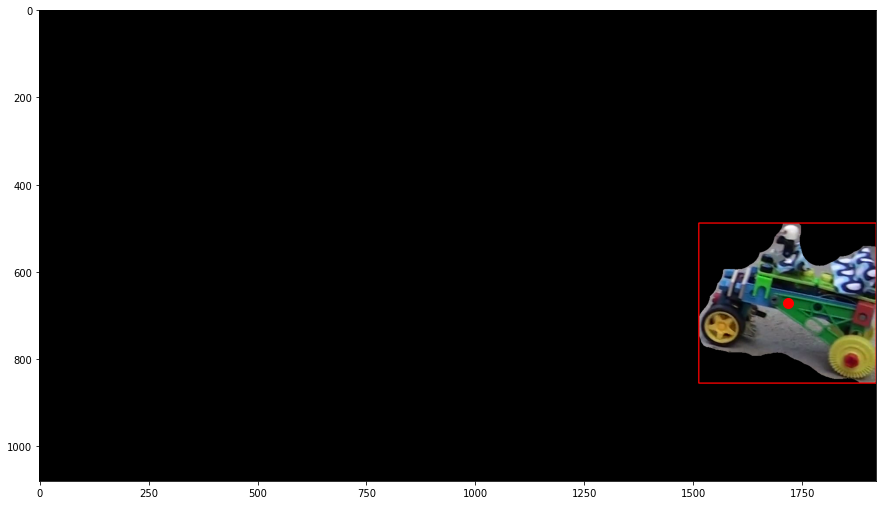

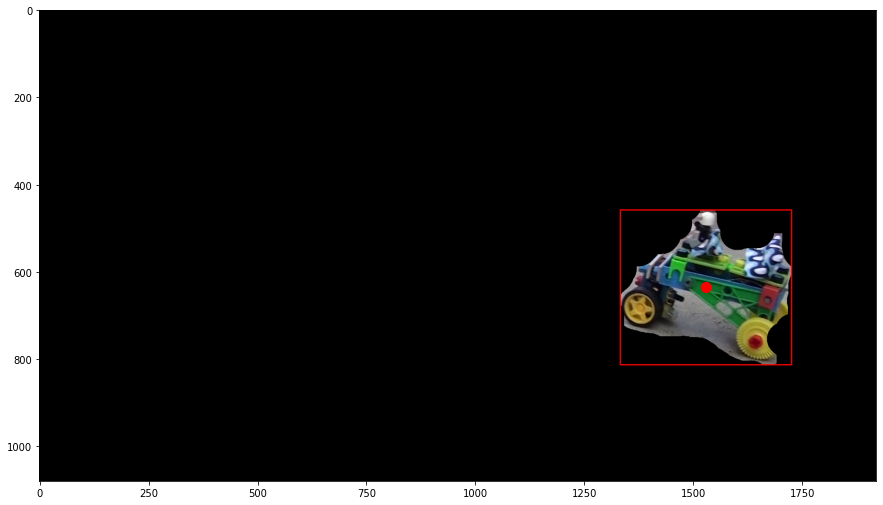

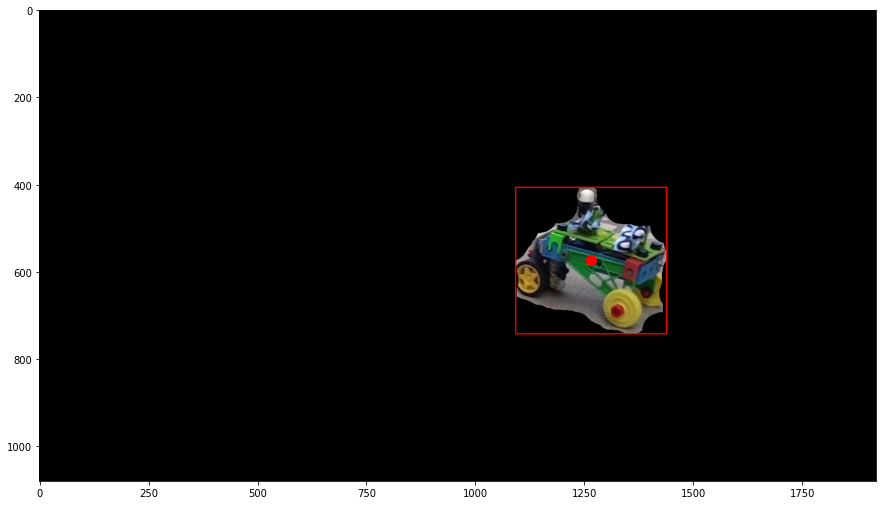

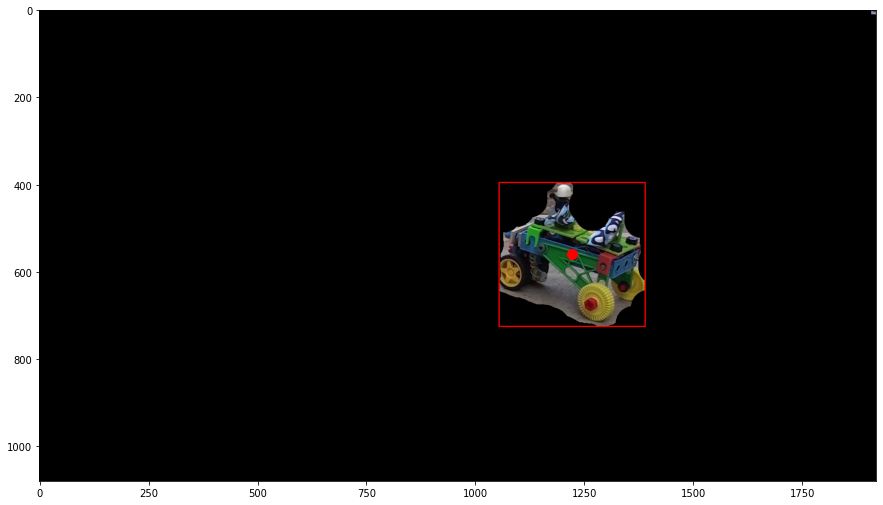

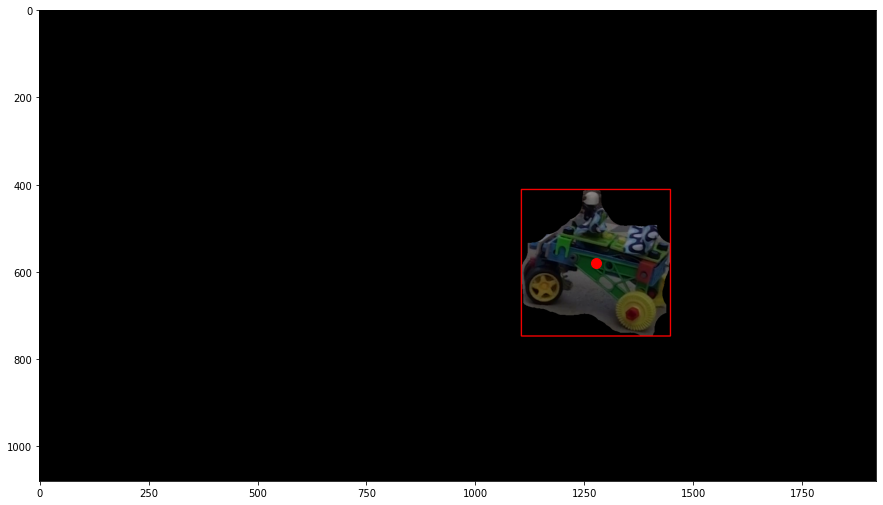

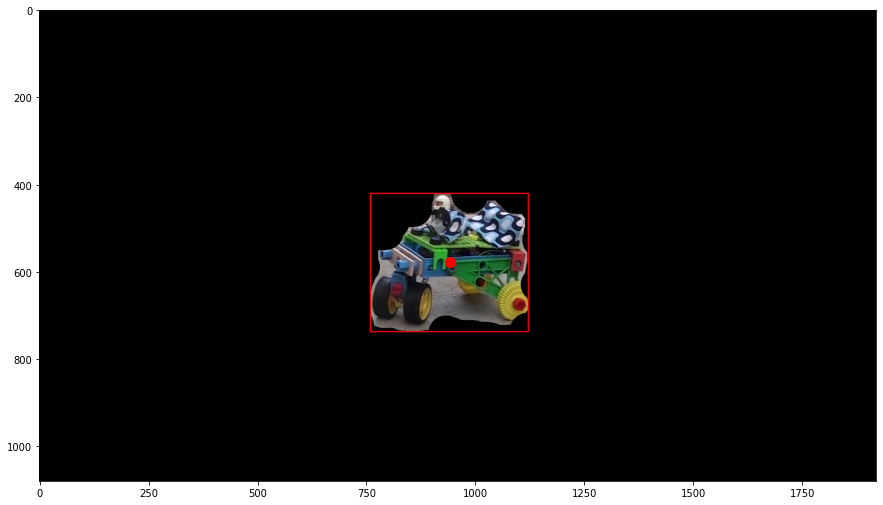

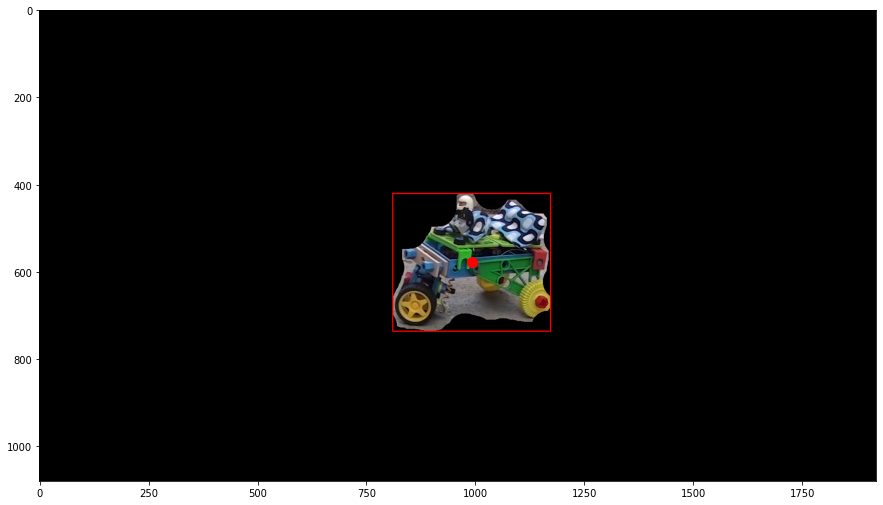

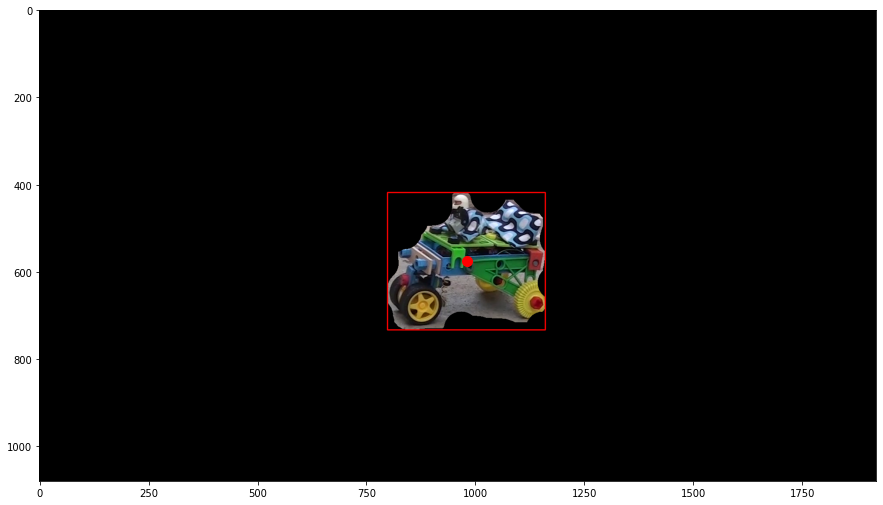

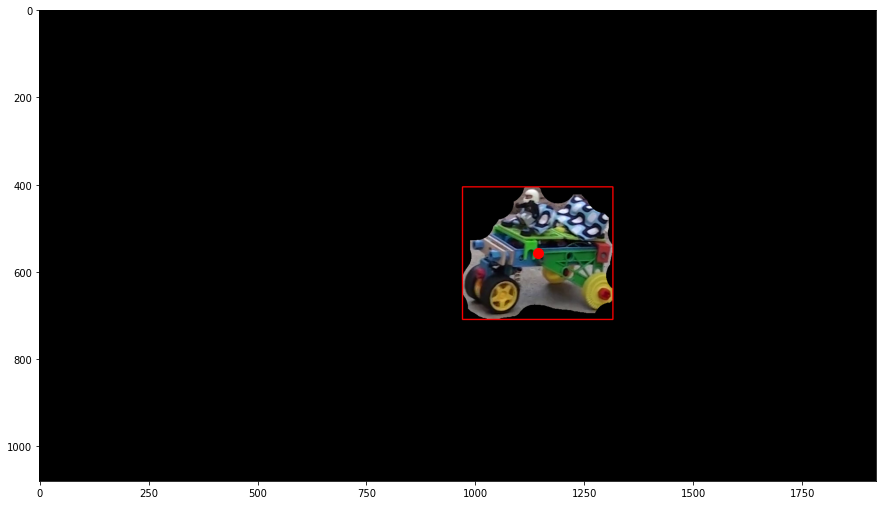

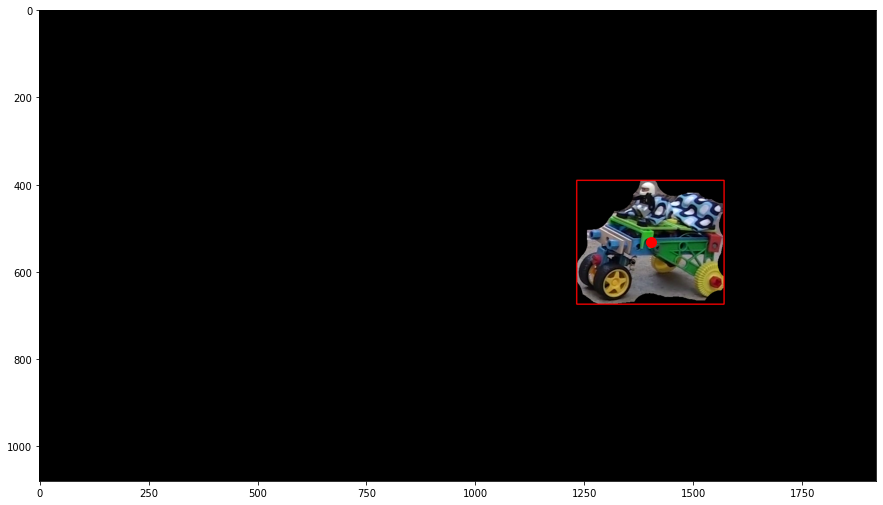

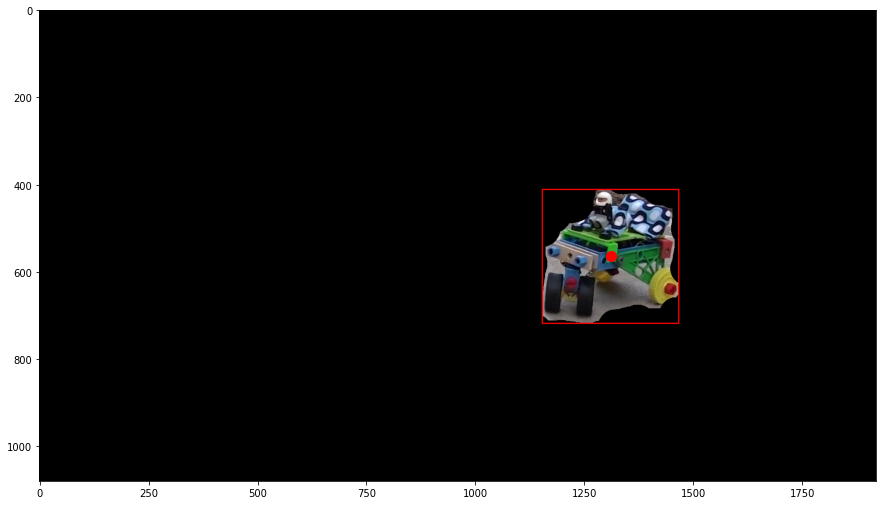

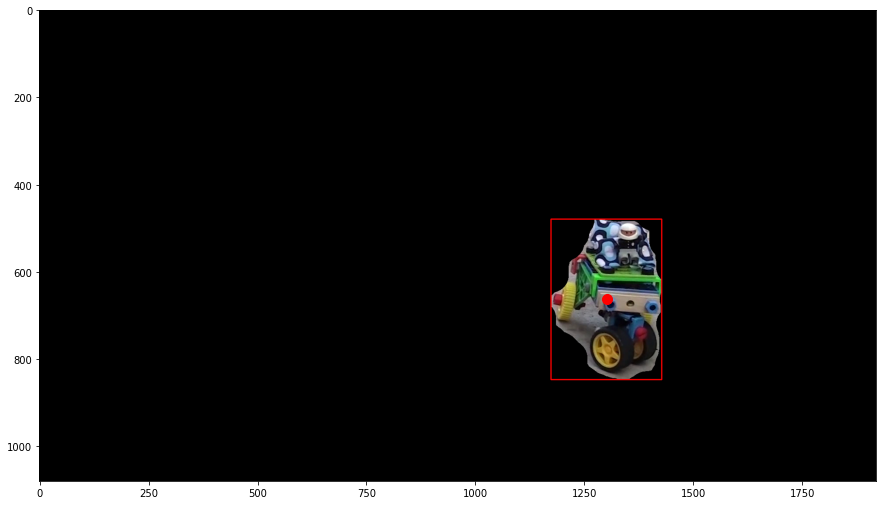

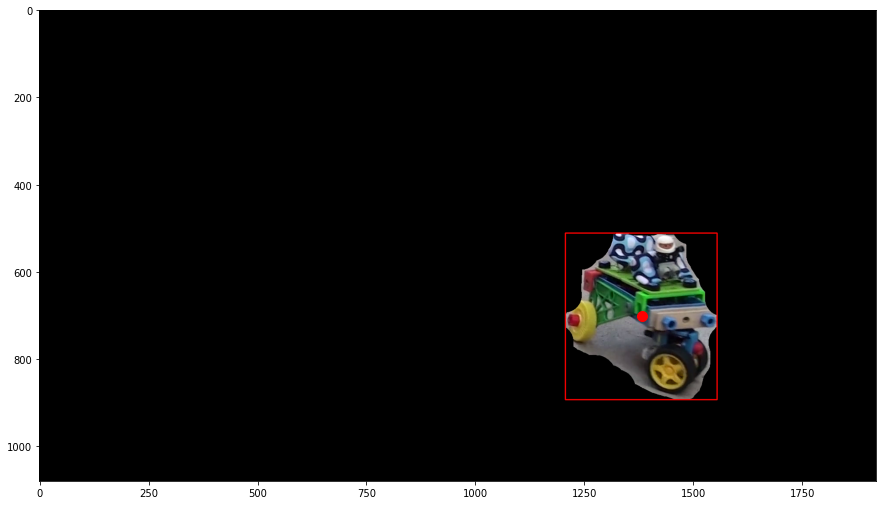

In [81]:
points = []
images = []

ref = get_ref_frame(dirs)

for dir_ in dirs:
    frame = cv.imread(dir_)
    center, segmented3d = get_cars_center(frame = frame, ref2 = ref, thres = 120)
    points.append(center)
    images.append(segmented3d)
print('Done')

In [82]:
points

[[1716, 671],
 [1529, 635],
 [1266, 574],
 [1222, 560],
 [1277, 579],
 [941, 578],
 [992, 578],
 [980, 575],
 [1143, 557],
 [1402, 532],
 [1310, 564],
 [1301, 663],
 [1381, 702]]

In [83]:
points.append(points[0]) #repeat the first point to create a 'closed loop'

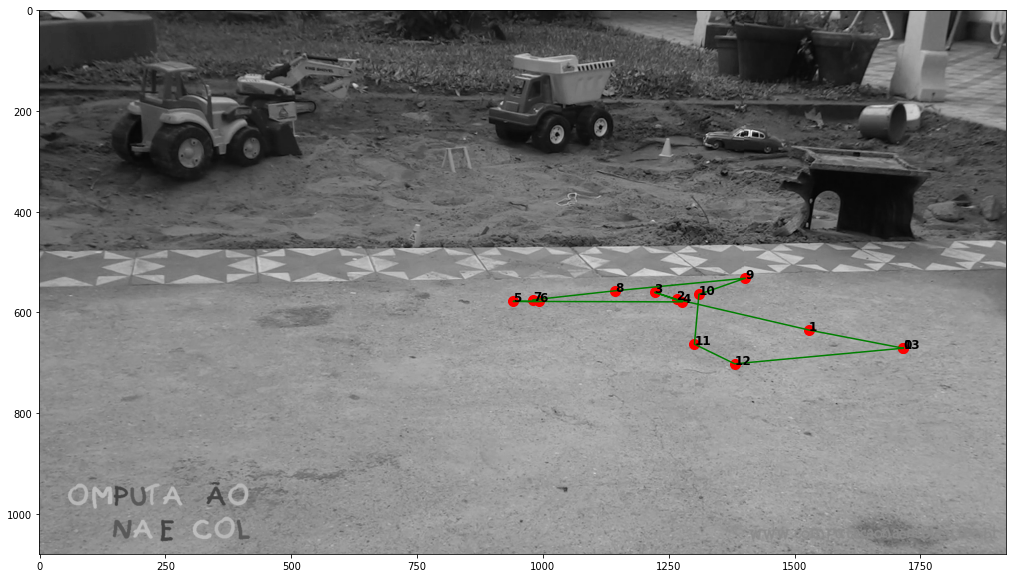

In [87]:
xs, ys = zip(*points) #create lists of x and y values

plt.figure(figsize = (18,10))

for i, point in enumerate(points):
    plt.plot(point[0], point[1], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
    plt.text(point[0], point[1], s = str(i), fontweight='bold', fontsize=12)

plt.imshow(ref, cmap = 'gray')
plt.plot(xs,ys, color='green')

Feedback: <br>

Achei o exercicio interessante, gostei da imagem index 4, por conta de ter um brilho menor do que as demais, as operações utilizadas não funcionavam como o esperado, <br>
foi ao enfrentar este problema que percebi que seria ideal que antes de iniciar a solução eu pudesse fazer com que todas as imagens fossem padronizadas de alguma forma. <br>
Inicialmente pensei em realizar equalização de histograma e fazer com que todas as imagens tivessem um mesmo valor medio, porém esta estrategia não foi eficiente devido <br>
ao fato do logo COMPUTAÇÃO NA ESCOLA continuar com o mesmo brilho na imagem index 4, desta forma ela ainda se diferenciava das demais. Com isso surgiu a ideia de remover <br>
a logo da imagem, assim, pude ajustar o brilho da imagem index 4. Para deixar a solução um pouco mais geral, as imagens são testadas para verificar se a media é inferior <br>
a um determinado threshold, se for há um ajuste dependente deste valor.

# Experimentação (processo de resolução do problema)

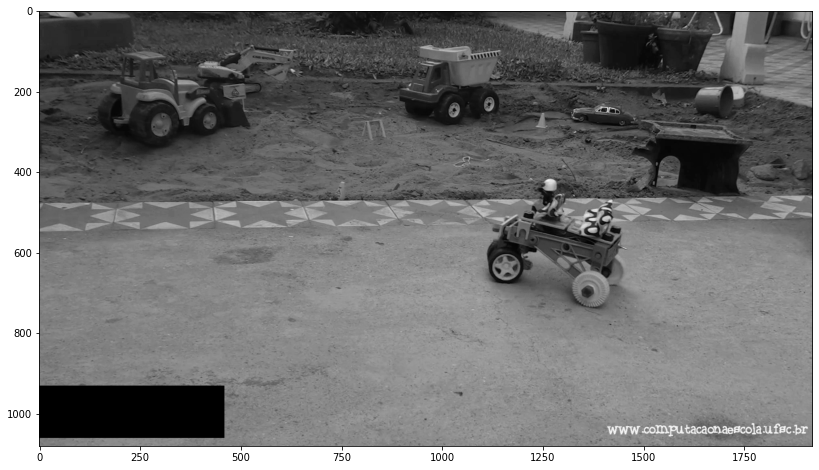

In [30]:
frame = cv.imread(dirs[4])
frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)


frame[930:1060,0:460] = 0

#clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(19,19))
#frame = clahe.apply(frame)
#frame = cv.equalizeHist(frame)

#thres = 120
#mean = np.mean(frame)
#frame = cv.multiply(frame, thres/mean)
plt.figure(figsize = (15,8))
plt.imshow(frame, cmap = 'gray')

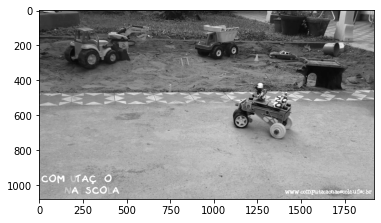

In [5]:
frame = cv.imread(dirs[4])

frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

#frame = np.uint8(((frame/255)**0.5)*255)

#clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(19,19))
#frame = clahe.apply(frame)
#frame = cv.equalizeHist(frame)

#thres = 120
#mean = np.mean(frame)
frame = cv.multiply(frame, 2.2)

plt.imshow(frame, cmap = 'gray')

# Experimentação (processo de resolução do problema)

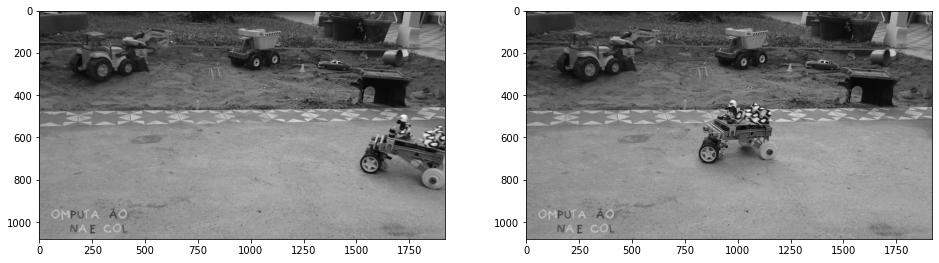

In [280]:
frame1rgb = cv.cvtColor(cv.imread(dirs[0]), cv.COLOR_BGR2RGB)
frame2rgb = cv.cvtColor(cv.imread(dirs[6]) , cv.COLOR_BGR2RGB)
     
frame1 = cv.cvtColor(frame1rgb, cv.COLOR_RGB2GRAY)
frame2 = cv.cvtColor(frame2rgb, cv.COLOR_RGB2GRAY)

plt.subplots(2,1, figsize=(16, 12))

plt.subplot(1, 2, 1)
plt.imshow(frame1, cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(frame2, cmap = 'gray')

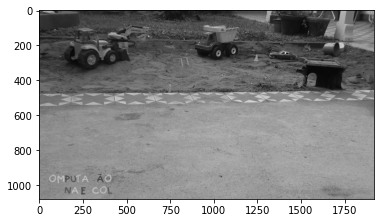

In [38]:
ref = np.zeros_like(frame1)

ref[:,:1400] = frame1[:,:1400] 
ref[:,1400:] = frame2[:,1400:]

plt.imshow(ref, cmap = 'gray')

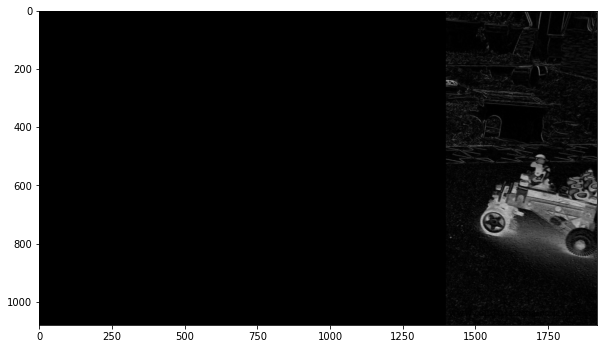

In [134]:
diff = cv.absdiff(frame1, ref)

plt.figure(figsize=(10, 6))
plt.imshow(diff, cmap = 'gray')

[[0 0 0 0 1 0 0 0 0]
 [0 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 0]
 [0 0 0 0 1 0 0 0 0]]


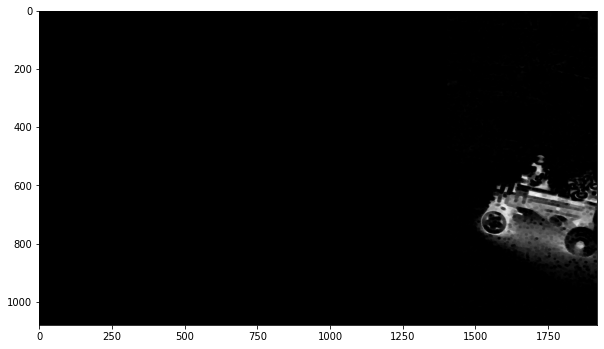

In [136]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(9,9))
print(kernel)
erode = cv.morphologyEx(diff, cv.MORPH_ERODE, kernel = kernel)

plt.figure(figsize=(10, 6))
plt.imshow(erode, cmap = 'gray')

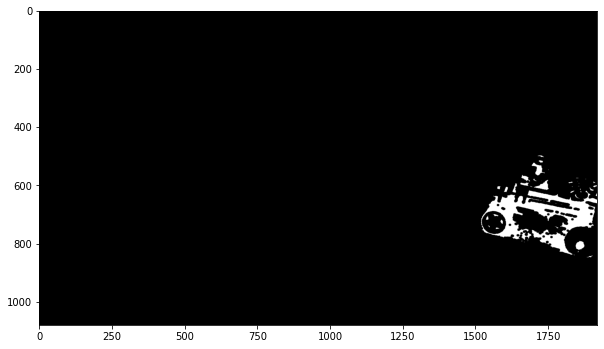

In [229]:
ret,thresh1 = cv.threshold(erode,50,255,cv.THRESH_BINARY)


plt.figure(figsize=(10, 6))
plt.imshow(thresh1, cmap = 'gray')

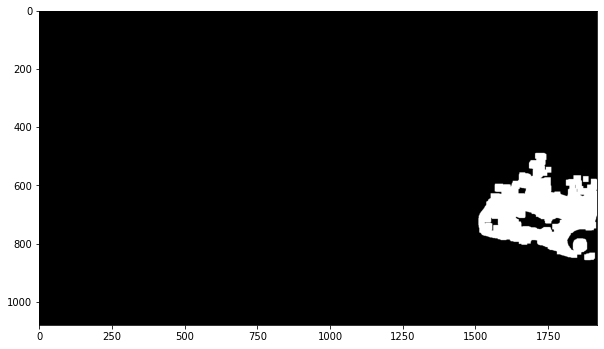

In [232]:
kernel = cv.getStructuringElement(cv.MORPH_RECT,(19,19))
dilate = cv.morphologyEx(thresh1, cv.MORPH_DILATE, kernel = kernel)

plt.figure(figsize=(10, 6))
plt.imshow(dilate, cmap = 'gray')

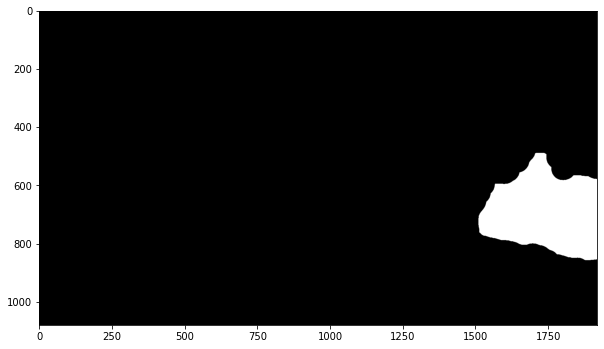

In [301]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(79,79))
mask = cv.morphologyEx(dilate, cv.MORPH_CLOSE, kernel = kernel)

plt.figure(figsize=(10, 6))
plt.imshow(mask, cmap = 'gray')
mask = (mask//255)

In [302]:
mask3d = cv.merge((mask,mask,mask))
mask3d.shape

(1080, 1920, 3)

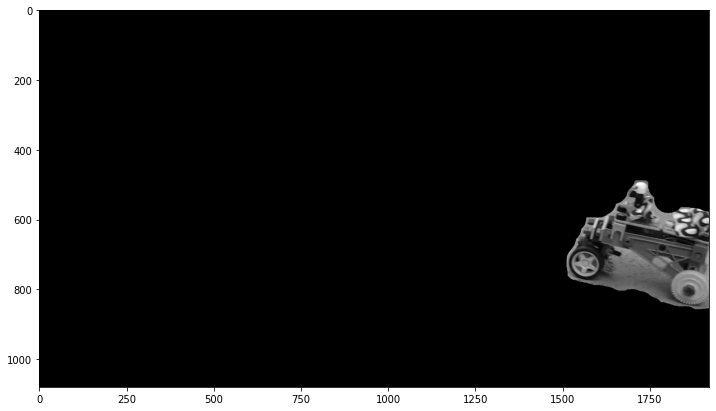

In [303]:
segmented = cv.multiply(frame1, mask)

plt.figure(figsize = (12,10))
plt.imshow(segmented, 'gray')

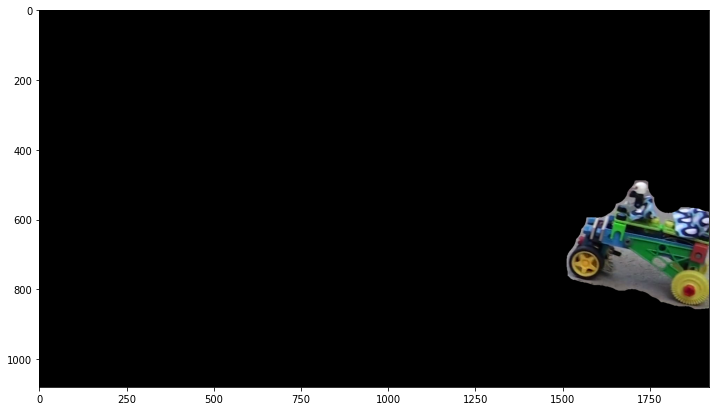

In [305]:
segmented3d = cv.multiply(frame1rgb, mask3d)

plt.figure(figsize = (12,10))
plt.imshow(segmented3d, 'gray')

In [306]:
cnts = cv.findContours(segmented, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

(x,y,w,h) = cv.boundingRect(cnts[0][0])

center = int(x + w/2) , int(y + h/2)

p1 = x , y
p2 = x + w , y + h

center

(1716, 672)

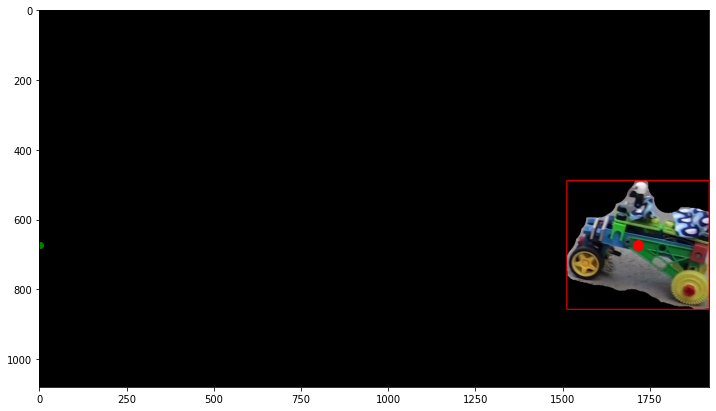

In [312]:
plt.figure(figsize = (12,10))
plt.plot(center, 'go', label='marker only')
segmented_and_bbox = cv.rectangle(segmented3d, p1, p2, color = (255,0,0), thickness = 2)
plt.plot(center[0], center[1], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
plt.imshow(segmented3d)

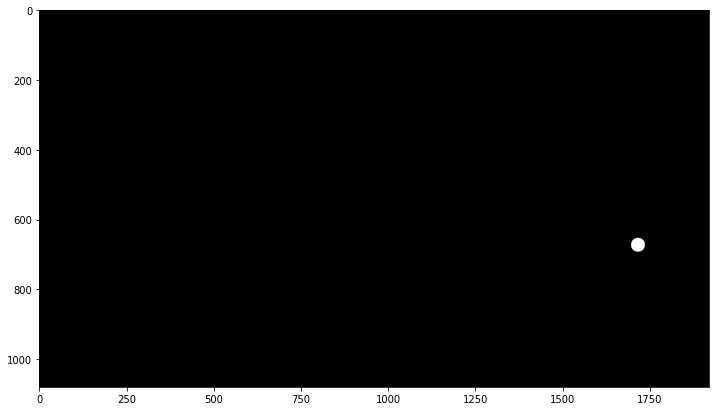

In [334]:
tragetory = cv.circle(img = np.zeros_like(ref), center = center, radius = 20, color = (255,0,0), thickness = -1)

plt.figure(figsize = (12,10))
plt.imshow(tragetory, cmap = 'gray')

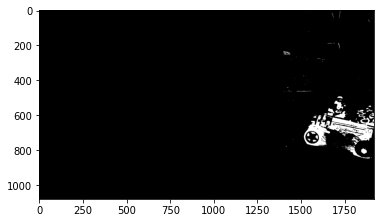

In [140]:
ret,thresh1 = cv.threshold(diff,80,255,cv.THRESH_BINARY)

plt.imshow(thresh1, cmap = 'gray')

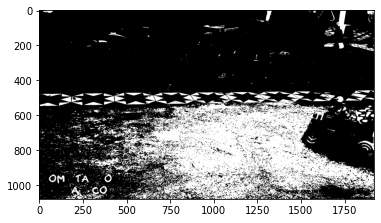

In [9]:
ret,thresh1 = cv.threshold(img,150,255,cv.THRESH_BINARY)

plt.imshow(thresh1, cmap = 'gray')